# FM FT API: Data Validation and \$Token Estimation

#### Usage Scenario:
This notebook goes hand-in-hand with Databricks-Mosaicml's FT API. Our customers may find it useful in scenarios where there is a risk of data being malformed. It acts as a preventive measure to ensure data integrity and helps in cost assessment for the fine-tuning process.

#### Script Purpose:
- **Not for Training**: This script is not utilized during the training process.
- **Ad-Hoc Validation**: It serves as an ad-hoc utility for users to run independently prior to starting fine-tuning.
- **Data Verification**: Its primary function is to validate the user's data before they invoke the Fine-Tuning (FT) API.
- **Cost Estimation**: Users can estimate the cost implications with this script.

#### Note on Long-Term Solution:
- **Future Development**: We are in the process of developing a long-term data preparation service, which will eventually replace this script.

#### User Defines:
- The inputs to this validation script is assumed to be the same or a subset of the FT API arguments, i.e., a configuration like below. 
- For the reference, FT API expects following
```
cfg = {
    model: str,
    train_data_path: str,
    save_folder: str,
    *,
    task_type: Optional[str] = "INSTRUCTION_FINETUNE",
    eval_data_path: Optional[str] = None,
    eval_prompts: Optional[List[str]] = None,
    custom_weights_path: Optional[str] = None,
    training_duration: Optional[str] = None,
    learning_rate: Optional[float] = None,
    context_length: Optional[int] = None,
    experiment_trackers: Optional[List[Dict]] = None,
    disable_credentials_check: Optional[bool] = None,
    timeout: Optional[float] = 10,
    future: Literal[False] = False,
}
``` 

# Installation

In [0]:
%pip uninstall -y llm-foundry

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
%pip install --upgrade --no-deps git+https://github.com/mosaicml/llm-foundry.git@byod/data_validation
%pip install 'mosaicml[libcloud,wandb,oci,gcs]>=0.23.4,<0.24'
%pip install 'mlflow>=2.14.1,<2.16'
%pip install 'transformers>=4.43.2,<4.44'
%pip install "mosaicml-streaming>=0.8.0,<0.9"
%pip install -U datasets
%pip install omegaconf
%pip install einops
%pip install sentencepiece

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Cloning https://github.com/mosaicml/llm-foundry.git (to revision byod/data_validation) to /tmp/pip-req-build-g0hhn4uw
  Running command git clone --filter=blob:none --quiet https://github.com/mosaicml/llm-foundry.git /tmp/pip-req-build-g0hhn4uw
  Running command git checkout -b byod/data_validation --track origin/byod/data_validation
  Switched to a new branch 'byod/data_validation'
  branch 'byod/data_validation' set up to track 'origin/byod/data_validation'.
  Resolved https://github.com/mosaicml/llm-foundry.git to commit 93c150602d4eede5af9acc0c1f266190e5807a2d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished w

In [0]:
dbutils.library.restartPython()

In [0]:
import os
import re
import json
import tempfile
import random
import numpy as np
import pandas as pd 
from collections import defaultdict
from argparse import ArgumentParser, Namespace
from typing import cast 

import datasets 

from llmfoundry.utils import (create_om_cfg, token_counts_with_collate, 
        check_HF_datasets, is_hf_dataset_path, is_uc_delta_table,
        integrity_check, convert_text_to_mds, parse_args, plot_hist,
)

from llmfoundry.data.finetuning.tasks import (_validate_chat_formatted_example,
                                              _tokenize_prompt_response_formatted_example,
                                              _get_example_type, ChatFormattedDict, PromptResponseDict )
import transformers
transformers.logging.set_verbosity_error()

Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name 'DefaultLoadPlanner' from partially initialized module 'torch.distributed.checkpoint.default_planner' (most likely due to a circular import) (/databricks/python/lib/python3.11/site-packages/torch/distributed/checkpoint/default_planner.py)
Unexpected internal error when monkey patching `Trainer.train`: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
Failed to import transformers.integrations.pe

# Instruction Fine Tuning

### Fine-Tuning API Arguments Configuration

This section of the notebook is dedicated to setting up the parameters for the validation notebook. These parameters should be identical to what you specify in Finetuning API. 

**Fine-Tuning API Arguments (FT_API_args):**

- model: Specifies the model to be used for fine-tuning. E.g., 'EleutherAI/gpt-neox-20b'
- train_data_path: The path to the training data. It can be either a huggingface dataset, a path to a jsonl file or a delta table.
- task_type: Defines the type of task for which the training strategy will be applied. It is either 'INSTRUCTION_FINETUNE' or 'CHAT_COMPLETION' or 'CONTINUED_PRETRAIN'.
- training_duration: The duration of the training process, expressed in numerical terms (e.g., 3) with units of training epochs.
- context_length: Specifies the context length of the model, set to 2048. This determines how many tokens the model considers for each training example.

**Temporary Data Path Configuration:**

- temporary_jsonl_data_path: Defines a filesystem path where temporary data related to the training process will be stored. You need to make sure the path should not be shared by other users on the cluster, as it costs contention.
- Environment variables for Hugging Face caches (HF_DATASETS_CACHE) are set to '/tmp/', directing dataset caching to a temporary directory.

**[Supported Models by FT API](https://docs.mosaicml.com/projects/mcli/en/latest/finetuning/finetuning.html#supported-models):**. 

You need to specify context length based on the model mapping below.
```
ft_models = {
  'mosaicml/mpt-7b-8k': 8192, 
  'mosaicml/mpt-7b': 2048,
  'mosaicml/mpt-30b': 8192,
  'meta-llama/Llama-2-13b-hf': 4096,
  'meta-llama/Llama-2-7b-hf': 4096,
  'meta-llama/Llama-2-70b-hf': 4096,
  'codellama/CodeLlama-7b-hf': 16384,
  'codellama/CodeLlama-13b-hf': 16384,
  'codellama/CodeLlama-34b-hf': 16384,
  'mistralai/Mistral-7B-v0.1': 32768,
}
```

In [0]:
# Make sure you have write access to the ``home`` directory
home = os.path.join('/local_disk0', 'ift')
os.makedirs(home, exist_ok=True)
os.chdir(home)

In [0]:
FT_API_args = Namespace(
    model= 'mosaicml/mpt-7b', # Other examples: 'EleutherAI/gpt-neox-20b',
    train_data_path= 'mosaicml/dolly_hhrlhf/train',  # Other examples: '/path/to/train.jsonl', 'catalog.schema.table', 'iamroot/chat_formatted_examples/train', 
    task_type='INSTRUCTION_FINETUNE', # 'CHAT_COMPLETION'
    training_duration=3,
    context_length=2048,
)

temporary_jsonl_data_path = os.path.join(home, 'ft_data_11Jan24_3/train')
os.environ['HF_DATASETS_CACHE'] = os.path.join(home, 'hf_cache')
os.makedirs(temporary_jsonl_data_path, exist_ok=True)
os.makedirs(os.environ['HF_DATASETS_CACHE'], exist_ok=True)

#### Data Loading

The IFT data needs to stay with a format 
```
prompt: xxx
response or completion: yyy
```

Based on FT_API_args.train_data_path, we will select an ingestion method from one of the three options below:

- Option-1. data is a JSONL file which stores in an object store supported by Composer.
- Option-2. data is a Huggingface dataset ID. Note you need to provide a split as well. 
- Option-3. data is a delta table. 

In [0]:
raw_dataset = None

if is_hf_dataset_path(FT_API_args.train_data_path):
    check_HF_datasets(FT_API_args.train_data_path)
    dataset_id, split = '/'.join(FT_API_args.train_data_path.split('/')[:2]), FT_API_args.train_data_path.split('/')[-1]    
    raw_dataset = datasets.load_dataset(dataset_id, split=split)       
else:
    if is_uc_delta_table(FT_API_args.train_data_path):    
        df = spark.read.table(FT_API_args.train_data_path).toPandas()
        df.to_json(os.path.join(temporary_jsonl_data_path, 'data.jsonl'), orient='records', lines=True)
        raw_dataset = datasets.Dataset.from_pandas(df) 
        FT_API_args.train_data_path = temporary_jsonl_data_path
    else: 
        # train_data_path is a jonsl file (local/remote)
        from composer.utils import dist, get_file, parse_uri 
        data_path = FT_API_args.train_data_path 
        backend, _, _ = parse_uri(data_path)
        if backend not in ['', None]: # It's a remote path, download before loading it
            with tempfile.TemporaryDirectory() as tmp_dir:
                destination = os.path.join(tmp_dir, 'data.jsonl')
                get_file(data_path, destination)
                df = pd.read_json(destination, orient='records', lines=True)    
        else: 
            df = pd.read_json(data_path, orient='records', lines=True)    

        raw_dataset = datasets.Dataset.from_pandas(df)
        FT_API_args.train_data_path = os.path.dirname(data_path)

if raw_dataset is None: 
    raise RuntimeError("Can't find a proper ingestion method")

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /local_disk0/ift/hf_cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS, UC Volumes].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/', '/Volumes/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


#### Data Quality Checks on the Dataset


This section of the notebook performs a series of checks on the initial dataset to ensure its quality and expected format. This process ensures that the dataset adheres to the expected structure and contains the necessary keys for further processing. The checks are outlined below.

1. The total number of examples in the dataset is printed.
2. The first example from the dataset is displayed. This provides a quick glimpse into the data structure and format.
3. Data Format Validation:
- The dataset is expected to consist of dictionary-like objects (key-value pairs). A check is performed to validate this structure.
Each example in the dataset is examined for its compliance with the expected format.
4. Key Presence Validation:
- Allowed prompt and response keys, chat roles are defined in [llmfoundry](https://github.com/mosaicml/llm-foundry/blob/main/llmfoundry/data/finetuning/tasks.py): _ALLOWED_RESPONSE_KEYS and _ALLOWED_PROMPT_KEYS and _ALLOWED_ROLES.
- For prompt response dataset, the script checks for the presence of at least one prompt key and one response key in each example.
  - Prompt Validation: Each example is checked for the presence of keys defined in _ALLOWED_PROMPT_KEYS. If no valid prompt key is found, it is counted as a format error. 
  - Response Validation: Similarly, each example is checked for the presence of keys defined in _ALLOWED_RESPONSE_KEYS. An absence of a valid response key is also counted as a format error.
- For chat formatted dataset, the script checks if the message content is formatted valid by calling [_validate_chat_formatted_example](https://github.com/mosaicml/llm-foundry/blob/cffd75e94e5c53b1b14c67cd17e0916fecfd0e16/llmfoundry/data/finetuning/tasks.py#L130) helper function.
Error Reporting:

If any format errors are found during the checks, they are reported.
A summary of errors is printed, categorizing them into types like data_type (non-dictionary data), missing_prompt, and missing_response.
If no errors are found, a congratulatory message is displayed, indicating that all checks have passed successfully.

In [0]:
# Initial dataset stats
print("Num examples:", len(raw_dataset))
print("First example:")
for ex in raw_dataset: 
    print(ex)
    print() 
    break 

format_errors = defaultdict(int)

for example in raw_dataset:
    try: 
        example_format = _get_example_type(ex)
    except ValueError:
        format_errors["unknown example type"] += 1 
        continue 

    if example_format == 'chat':
        try: 
            chat_example = cast(ChatFormattedDict, example)
            _validate_chat_formatted_example(chat_example)
        except Exception as e:             
            format_errors['chat_format_error'] += 1  
            print(e)
            break 

    elif example_format == 'prompt_response':
        try:
            prompt_response_example: PromptResponseDict = cast(
                PromptResponseDict, example)
        except Exception as e: 
            format_errors['prompt_response_format_error'] += 1  
            print(e)
            break 
        
if format_errors:
    print("Oops! Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("Congratulations! No errors found")    

Num examples: 59310
First example:
{'prompt': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nwhat is kangen water?\n\n### Response:\n', 'response': 'Kangen water is alkaline ionized water produced through a process called electrolysis.  Kangen water is also referred to electrolyzed reduced water.  This water is characterized by an large negative oxidation reduction potential and a potential hydrogen level > 7.0 making the water alkaline.  It is also infused with molecular hydrogen in the amount of 1 - 1.5 parts per million per gallon of water produced.  This infused hydrogen has been shown to be a very good anti-inflammatory for the body.'}

Congratulations! No errors found


#### Token Estimation

Tokenize the raw dataset and let's some statistics of the tokens and estimate the overall cost based on default trainining duration
We will iterate over the dataloader and sum the number of tokens from each batch. 

In [0]:
n_epochs = FT_API_args.training_duration if FT_API_args.training_duration is not None else 1 
batch_tokens = token_counts_with_collate(FT_API_args)
n_billing_tokens_in_dataset = sum(batch_tokens['ntokens'])

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /local_disk0/ift/hf_cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS, UC Volumes].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/', '/Volumes/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5c0e8cd-af43-4421-8e74-d6648cb9e313/lib/python3.11/site-packages/llmfoundry/da

List of Token length (num_proc=4):   0%|          | 0/59284 [00:00<?, ? examples/s]

/local_disk0/.ephemeral_nfs/envs/pythonEnv-e5c0e8cd-af43-4421-8e74-d6648cb9e313/lib/python3.11/site-packages/llmfoundry/data/finetuning/collator.py:367: UserWarning: Truncating sequence of length=2140 to fit max_seq_len=2048. If truncation is a problem, consider increasing max_seq_len.
  warnings.warn(


Finetuning API will internally ingest the dataset and run tokenization with the selected tokenizer. 
The output dataset will be a collection of samples. Each sample is a collection of token ids represented as integers.  
We generate a histogram that visualizes the distribution of frequency of token counts in samples in the dataset. 
The visualization aids in identifying patterns, outliers, and central tendencies in the token distribution.

Dataset has ~9646381 tokens that will be used by the model during training
Assume you'll train for 3 epochs on this dataset
Then ~28939143 tokens will be running through the model during training


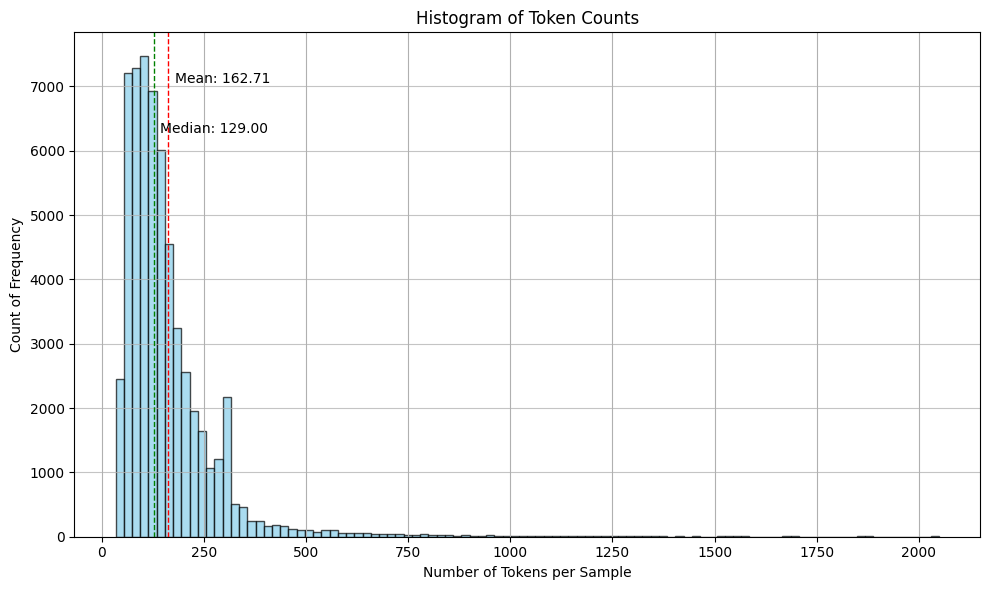

In [0]:
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be used by the model during training")
print(f"Assume you'll train for {n_epochs} epochs on this dataset")
print(f"Then ~{n_epochs * n_billing_tokens_in_dataset} tokens will be running through the model during training")
plot_hist(pd.Series(batch_tokens['ntokens']))

# Continued Pretrain

### Continued Pretrain API Arguments Configuration

Similar to Instruction Finetune, you need to specify

**Fine-Tuning API Arguments (FT_API_args):**

- model: Specifies the model to be used for fine-tuning. E.g., 'EleutherAI/gpt-neox-20b'
- train_data_path: The path to the training data. We currently only support a (remote/local) path to a collection of .txt files.
- task_type: Defines the type of task for which the training strategy will be applied. It is either 'INSTRUCTION_FINETUNE' or 'CONTINUED_PRETRAIN'.
- training_duration: The duration of the training process, expressed in numerical terms (e.g., 3) with units of training epochs.
- context_length: Specifies the context length of the model, set to 2048. This determines how many tokens the model considers for each training example. For Continued Pretraining, we concatenate tokens to form samples of length equal to context_length

**Temporary Data Path Configuration:**

- temporary_mds_output_path: Defines a filesystem path where notebook running data can be stored. You need to make sure the path should not be shared by other users on the cluster, as it costs contention. For example, you can make it distinguishable by adding your username to the path.

**[Supported Models by FT API](https://docs.mosaicml.com/projects/mcli/en/latest/finetuning/finetuning.html#supported-models):**. 

You need to specify context length based on the model mapping below.
```
ft_models = {
  'mosaicml/mpt-7b-8k': 8192, 
  'mosaicml/mpt-7b': 2048,
  'mosaicml/mpt-30b': 8192,
  'meta-llama/Llama-2-13b-hf': 4096,
  'meta-llama/Llama-2-7b-hf': 4096,
  'meta-llama/Llama-2-70b-hf': 4096,
  'codellama/CodeLlama-7b-hf': 16384,
  'codellama/CodeLlama-13b-hf': 16384,
  'codellama/CodeLlama-34b-hf': 16384,
  'mistralai/Mistral-7B-v0.1': 32768,
}
```

In [0]:
FT_API_args = Namespace(
    model= 'mosaicml/mpt-7b',
    train_data_path= os.path.join(home, 'ABT'), # this is the path to your collection of txt files
    task_type='CONTINUED_PRETRAIN',
    training_duration=3,
    context_length=8,
)
temporary_mds_output_path = os.path.join(home, 'mds_data_11Jan24_5')

Generate a synthetic dataset. Replace train_data_path with your raw data path in practice.

In [0]:
def generate_synthetic_dataset(folder_path, num_files=128):
    """Generate a synthetic dataset of text files with random words."""
    def generate_random_words(num_words=50):
        words = ["apple", "banana", "cherry", "date", "elderberry", "fig", "grape", "honeydew", "kiwi", "lemon", "mango", "nectarine", "orange", "papaya", "quince", "raspberry", "strawberry", "tangerine", "ugli", "vanilla", "watermelon", "xigua", "yam", "zucchini"]
        return ' '.join(random.choice(words) for _ in range(num_words))

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for i in range(num_files):
        file_path = os.path.join(folder_path, f"file_{i}.txt")
        with open(file_path, 'w') as file:
            file.write(generate_random_words())

    print(f"Generated {num_files} files in '{folder_path}'.")

generate_synthetic_dataset(FT_API_args.train_data_path)

Generated 128 files in '/local_disk0/ift/ABT'.


In [0]:
!rm -rf {temporary_mds_output_path}

#### Ingestion, Tokenization and Materialization

CPT takes a folder of txt files as input. It tokenize the text fields and materialize as a streaming dataset of MDS format. 

FT API uses [llmfoundry/scripts/data_prep/convert_text_to_mds.py](https://github.com/mosaicml/llm-foundry/blob/main/scripts/data_prep/convert_text_to_mds.py) to download all the txt files and convert them to MDS. 

In this notebook, we provide two additional approaches via Spark and Dask. 

**Warning** CPT datasets are normally much larger than IFT, so the tokenization and materialization can be very time consuming. 

In [0]:
import os
os.makedirs(temporary_mds_output_path, exist_ok=True)

In [0]:
cfg, tokenizer = create_om_cfg(FT_API_args)

input_folder = FT_API_args.train_data_path
output_folder = temporary_mds_output_path
concat_tokens = FT_API_args.context_length
tokenizer_name = FT_API_args.model

# Run convert_text_to_mds.py and dump MDS dataset to "save_folder"
args = parse_args(tokenizer_name, concat_tokens, output_folder, input_folder)

n_samples = convert_text_to_mds(
    tokenizer_name=args.tokenizer,
    output_folder=args.output_folder,
    input_folder=args.input_folder,
    concat_tokens=args.concat_tokens,
    eos_text=args.eos_text,
    bos_text=args.bos_text,
    no_wrap=args.no_wrap,
    compression=args.compression,
    processes=1,
    reprocess=True,
    args_str=str(args), 
    trust_remote_code=False)

n_billing_tokens_in_dataset = n_samples * concat_tokens

#### Token Estimation

In [0]:
MAX_TOKENS_PER_EXAMPLE = FT_API_args.context_length if FT_API_args.context_length is not None else 4096
TARGET_EPOCHS = FT_API_args.training_duration if FT_API_args.training_duration is not None else 1 
n_epochs = TARGET_EPOCHS

print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, ~{n_epochs * n_billing_tokens_in_dataset} tokens will be used in training")

Dataset has ~11864 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, ~35592 tokens will be used in training
